In [3]:
import os, scipy, sys, pandas as pd, numpy as np, datetime, seaborn as sns

In [4]:
from util import *

In [5]:
# input input and output directories
input_dir = input('Enter the path to the folder containing the input files: ')
output_dir = input('Enter the path to the folder containing the output files: ')

In [7]:
# input metadata related to the experiment
keyword = input('Enter the common keyword in input file (csv, ROA mask and cell mask) names: ')
experiment_date = input('Enter the experiment date (e.g. 2023-11-06): ')
mouse_ID = input('Enter the mouse ID: ')
slice_number = int(input('Enter the slice number: '))
drug_frame = float(input('Enter the frame number of drug application (enter NA if no drug was applied): '))
frame_rate = int(input("Enter the frame rate (in Hz) of the recording (e.g. 20): "))
output_filename = input('Enter the output file name: ') + '.xlsx'
output_path = os.path.join(output_dir, output_filename)


In [8]:
# find the input files
csv_path, ROA_mask_path, cell_mask_path = find_files(input_dir, keyword)

Found the following files: 

CSV file:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu.csv
ROA mask:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu_roa_mask.tif
Cell mask:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu_cell_mask.tif


In [9]:
ROA_map_labeled, ROA_map_count, cell_map_labeled, cell_count = read_masks(ROA_mask_path, cell_mask_path)

ROA mask contains 452 ROAs
Cell mask contains 24 cells


In [9]:
filtered_traces = raw_to_filtered(csv_path)

Reading in file:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu.csv 


The current file contains: 
Number of ROA:  452
Number of frames:  611

Applying a lowpass Butterworth filter with a 4 th order filter at the cutoff of 0.4 Hz


In [10]:
ROA_count, frame_count = check_traces(filtered_traces)

The current file contains: 
Number of ROA:  452
Number of frames:  611


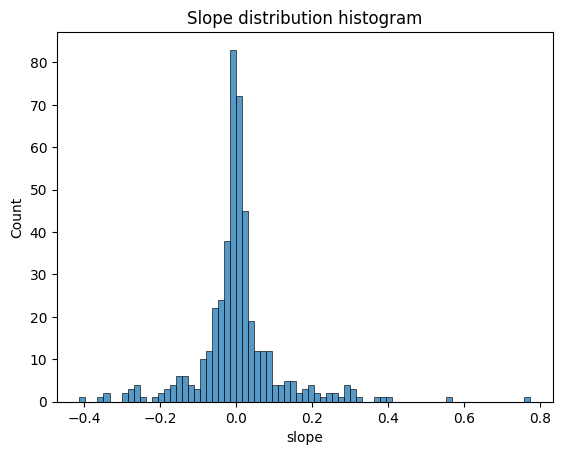

In [11]:
corrected_traces, reg = correct_shift(filtered_traces)

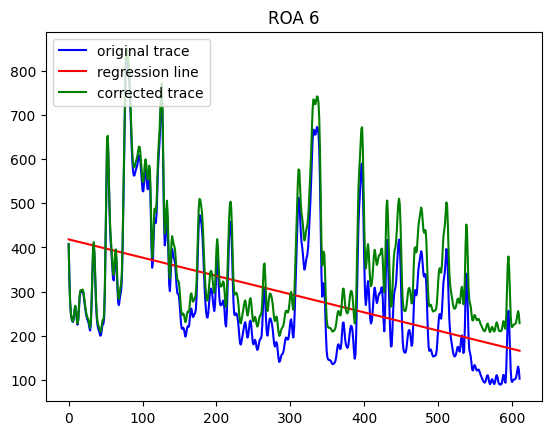

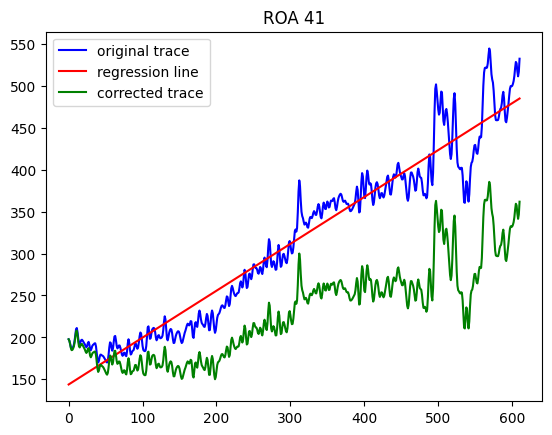

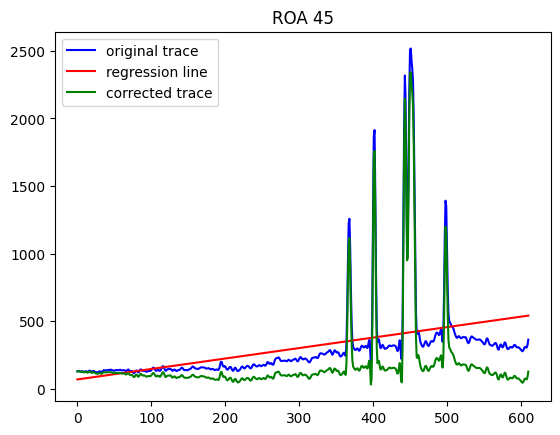

In [12]:
# optional visualization point
check_correction(filtered_traces, corrected_traces, reg)

In [14]:
dff_traces, baselines, thresholds, signal_frames, signal_boundaries = iterative_baseline(corrected_traces)


Processing round 1 of signal detection...
ROAs with signal:  372
ROAs without signal:  80

Processing round 2 of signal detection...
ROAs with signal:  369
ROAs without signal:  83

Processing round 3 of signal detection...
ROAs with signal:  371
ROAs without signal:  81

Processing round 4 of signal detection...
ROAs with signal:  369
ROAs without signal:  83

Processing round 5 of signal detection...
ROAs with signal:  371
ROAs without signal:  81

Processing round 6 of signal detection...
ROAs with signal:  368
ROAs without signal:  84



In [22]:
# optional: visualize specific trace
inspect_trace(1, dff_traces, baselines, thresholds, drug_frame)

TypeError: inspect_trace() takes 4 positional arguments but 5 were given

In [23]:
# analyze signals and output signal_stats
signal_stats = analyze_signal(dff_traces,signal_frames, signal_boundaries, frame_rate, drug_frame)

In [24]:
signal_stats.head()

ROA_ID  signal_start_index  signal_end_index  peak_index  peak_time  \
0       1                  88               378         284      284.0   
1       2                 461               490         470      470.0   
2       2                 579               593         583      583.0   
3       3                  58               116          73       73.0   
4       3                 141               216         194      194.0   

         AUC  amplitude  signal_to_noise   rise_time  decay_time  half_width  \
0  63.434950   0.727281         2.380849  125.790442   90.909620    0.358143   
1  11.995233   0.935390         0.983459    6.699639   18.602427    0.461028   
2   7.336736   1.751251         1.841246    2.473212    2.974016    0.854153   
3  18.196416   0.548747         0.431809   12.544874   36.601809    0.268499   
4  66.584956   4.652379         3.660961    3.484293    9.172385    2.313394   

   duration  inter_event_interval    Drug  
0     290.0                   NaN  Before  
1      29.0                   NaN   After  
2      14.0                  89.0   After  
3      58.0                   NaN  Before  
4      75.0                  25.0   After

In [25]:
# add corresponding cell ID to the signal stats
df_ROA_cell = align_ROA_cell(ROA_map_labeled, cell_map_labeled, ROA_map_count)
signal_stats = pd.merge(df_ROA_cell, signal_stats, on = 'ROA_ID', how = 'right')

In [27]:
signal_stats.head(10)

ROA_ID  cell_ID  signal_start_index  signal_end_index  peak_index  \
0       1        1                  88               378         284   
1       2        1                 461               490         470   
2       2        1                 579               593         583   
3       3        1                  58               116          73   
4       3        1                 141               216         194   
5       3        1                 274               282         278   
6       3        1                 284               296         292   
7       3        1                 419               431         423   
8       3        1                 432               456         452   
9       4        4                  13               125          78   

   peak_time        AUC  amplitude  signal_to_noise   rise_time  decay_time  \
0      284.0  63.434950   0.727281         2.380849  125.790442   90.909620   
1      470.0  11.995233   0.935390         0.983459    6.699639   18.602427   
2      583.0   7.336736   1.751251         1.841246    2.473212    2.974016   
3       73.0  18.196416   0.548747         0.431809   12.544874   36.601809   
4      194.0  66.584956   4.652379         3.660961    3.484293    9.172385   
5      278.0   2.674930   0.758558         0.596910    2.371855    2.651141   
6      292.0   2.448237   0.519600         0.408874    5.963485    2.497073   
7      423.0   4.817576   1.035187         0.814590    2.139157    6.616033   
8      452.0   9.178826   1.223365         0.962667    2.884053    2.827901   
9       78.0  31.498965   1.323758         4.885141    8.391351    9.662569   

   half_width  duration  inter_event_interval    Drug  
0    0.358143     290.0                   NaN  Before  
1    0.461028      29.0                   NaN   After  
2    0.854153      14.0                  89.0   After  
3    0.268499      58.0                   NaN  Before  
4    2.313394      75.0                  25.0   After  
5    0.369107       8.0                  58.0   After  
6    0.254341      12.0                   2.0   After  
7    0.499106      12.0                 123.0   After  
8    0.610011      24.0                   1.0   After  
9    0.654476     112.0                   NaN  Before

In [28]:
ROA_based, df_ROA_cell = ROA_analysis(signal_stats, df_ROA_cell)

/Users/mikodai/Desktop/STARDUST/src/util.py:421: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(df.Drug == 'Before'): # force into a int to bypass series ambiguity


In [29]:
ROA_based

ROA_ID  cell_ID  ROA_type    Drug  signal_start_index  signal_end_index  \
0         1        1       off  Before           88.000000        378.000000   
1         2        1        on   After          520.000000        541.500000   
2         3        1    stable   After          310.000000        336.200000   
3         3        1    stable  Before           58.000000        116.000000   
4         4        4    stable   After          422.857143        465.857143   
..      ...      ...       ...     ...                 ...               ...   
695     448       24  inactive     NaN                 NaN               NaN   
696     449       24  inactive     NaN                 NaN               NaN   
697     450       24  inactive     NaN                 NaN               NaN   
698     451       24       off  Before          110.000000        339.000000   
699     452       24  inactive     NaN                 NaN               NaN   

     peak_index   peak_time        AUC  amplitude  signal_to_noise  \
0    284.000000  284.000000  63.434950   0.727281         2.380849   
1    526.500000  526.500000   9.665984   1.343321         1.412353   
2    327.800000  327.800000  17.140905   1.637818         1.288800   
3     73.000000   73.000000  18.196416   0.548747         0.431809   
4    431.142857  431.142857  18.980547   1.548545         5.714686   
..          ...         ...        ...        ...              ...   
695         NaN         NaN        NaN        NaN              NaN   
696         NaN         NaN        NaN        NaN              NaN   
697         NaN         NaN        NaN        NaN              NaN   
698  184.000000  184.000000  39.092189   0.886491         2.632045   
699         NaN         NaN        NaN        NaN              NaN   

      rise_time  decay_time  half_width  duration  inter_event_interval  \
0    125.790442   90.909620    0.358143     290.0                   NaN   
1      4.586426   10.788221    0.657590      21.5             89.000000   
2      3.368569    4.752906    0.809192      26.2             41.800000   
3     12.544874   36.601809    0.268499      58.0                   NaN   
4      4.950604    6.159905    0.761335      43.0             21.428571   
..          ...         ...         ...       ...                   ...   
695         NaN         NaN         NaN       NaN                   NaN   
696         NaN         NaN         NaN       NaN                   NaN   
697         NaN         NaN         NaN       NaN                   NaN   
698   27.334943   38.541936    0.441942     229.0                   NaN   
699         NaN         NaN         NaN       NaN                   NaN   

     signal_count  
0             1.0  
1             2.0  
2             5.0  
3             1.0  
4             7.0  
..            ...  
695           NaN  
696           NaN  
697           NaN  
698           1.0  
699           NaN  

[700 rows x 17 columns]

In [30]:
df_ROA_cell

ROA_ID  cell_ID  ROA_type
0         1        1       off
1         2        1        on
2         3        1    stable
3         4        4    stable
4         5        4        on
..      ...      ...       ...
447     448       24  inactive
448     449       24  inactive
449     450       24  inactive
450     451       24       off
451     452       24  inactive

[452 rows x 3 columns]

In [31]:
df_ROA_cell.groupby('ROA_type').count()

ROA_ID  cell_ID
ROA_type                 
inactive      84       84
off           14       14
on           106      106
stable       248      248

In [35]:
import rasterio
from rasterio.plot import show

In [34]:
with rasterio.open(ROA_mask_path) as image:
    ROA_array = image.read()

/Users/mikodai/Desktop/STARDUST/.venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


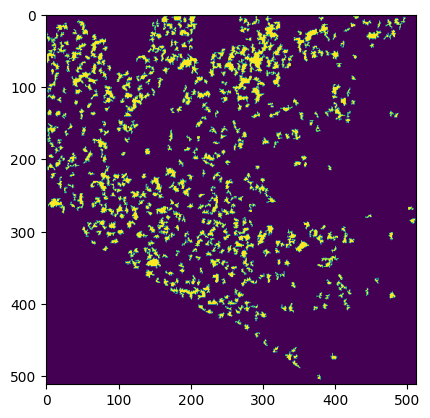

<Axes: >

In [36]:
show(ROA_array)

In [37]:
type(ROA_array)

numpy.ndarray

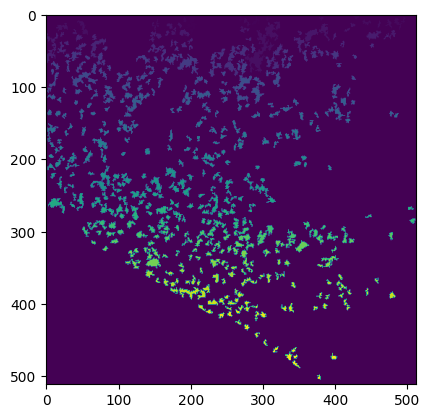

In [50]:
show(ROA_map_labeled);

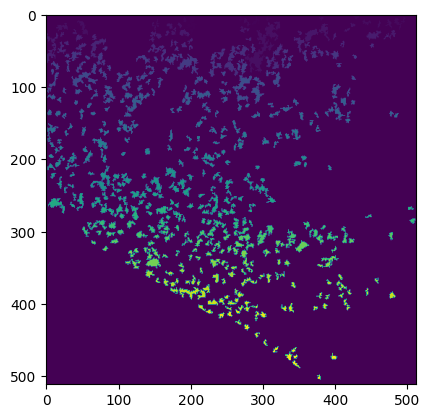

In [49]:
plt.imshow(ROA_map_labeled);

In [12]:
import plotly.express as px
fig = px.imshow(ROA_map_labeled,
                labels = dict(x = 'X', y = 'Y', color = 'ROA ID'))
fig.show()